**Libraries Needed**

In [788]:
#Pandas & NumPy & SciPy 
import numpy as np
import pandas as pd

#Preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

#Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

#Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score 
from scipy.stats import shapiro

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Regression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

****

### Linear Regression Final Project - Regression Software

* **Function 1**

`preprocess(dataset,target,separator)` : removes null values, encodes target if it is an object , splits the data into train and test & scales the data 
* __dataset__ - dataset of choice
* __separator__ - how your data is separated ( __' ; '__ , __' , '__ , __' '__) , initially set to `none`
* __target__ - target variable 

In [773]:
def preprocess(dataset,target,separator = None): 
    
    df = pd.read_csv(dataset, sep = separator)
    
    filtered_df = df.dropna(axis=1) #Drops all missing values 
    
    #If variable is an object, then encode it
    
    
    encoded_df = filtered_df.select_dtypes(include='object') #Gets all columns with an object type
    
    if target in encoded_df: #If our target is of dtype object
        
        le = LabelEncoder() #Label encoder instance
        filtered_df['Encoded'] = le.fit_transform(encoded_df[target]) #Making encoded column of object column
        del filtered_df[target] #Deleting the column of object type 
        target = 'Encoded' #Our new target column, the encoded column
    
    
    
    X = filtered_df.drop(target,axis=1).values #All other features 
    Y = filtered_df[[target]].values #Target Response
    
    #Splitting into train and test (20% test)
    train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size = 0.2, random_state = 0) 
    
    #Scales the data
    scaler = StandardScaler()
    train_x = scaler.fit_transform(train_x)
    test_x = scaler.transform(test_x)
    
    
    return filtered_df, X, Y, train_x, test_x, train_y, test_y #Returns the train and test sets 

* **Function 2**

`select_features(X_train, y_train, X_test)` : selects the best features for the model
* __X_train__ - Training Set
* __y_train__ - Target Variable in Training Set
* __X_test__ - Test Set

In [774]:
def select_features(X_train, y_train, X_test):
    
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    
    # learn relationship from training data
    fs.fit(X_train, y_train)
    
    # transform train input data
    X_train_fs = fs.transform(X_train)
    
    # transform test input data
    X_test_fs = fs.transform(X_test)
    
    return X_train_fs, X_test_fs, fs

* **Function 3**

`diagnostics(df, y_true, y_pred)` : gets the diagnostics for the model (Linearity, Normality, Homoskedascity) 
* __df__ - dataset of choice
* __y_true__ - True Values of Target Variable
* __y_pred__ - Predicted Values of Target Variable

In [792]:
def diagnostics(df, y_true, y_pred): 
    
    #Tests for normality 
    statistic, p = shapiro(df) 
    alpha = 0.05
    
    print("Tests for Homoskedascity, Linearity & Normality : (Graph of Residual vs Predicted below)")
    
    print("Shapiro-Wilk Test : ")
    if p > alpha : 
        print("Sample is Normal (Accept H_o)")
        print("p-value larger than 0.05")
        
    else:
        print("Sample is not Normal (Reject H_o)")
        print("p-value smaller than 0.05")
    print('\n')
        
        
    #Tests for Homoskedascitiy & Linearity 
    
    residual = y_true - y_pred #Residual = TrueValue - PredictedValue 
    
    plt.plot(y_true, residual, 'o',color='green')
    plt.xlabel("Predicted")
    plt.ylabel("Residuals")
    plt.title('Predicted vs Residuals')
    plt.axhline(y=0)
        

* **Function 4**

`regression(df, X, Y, train_x, test_x, train_y, test_y)` : Performs regression using OLS, Lasso, Ridge and gives the best model 
* __df__ - dataset of choice
* __X__ - Dataframe of all features except target given by preprocess()
* __Y__ - Dataframe of target given by preprocess()
* __train_x__ - Train Set
* __test_x__ - Test Set
* __train_y__ - Target in Training Set
* __test_y__ - Target in Test Set

In [776]:
def regression(df, X, Y, train_x, test_x, train_y, test_y): 
    
    #Linear Regression
    OLS_model = LinearRegression() 
    OLS_model.fit(train_x,train_y) #Fitting train data to model 
    OLS_pred = OLS_model.predict(test_x) #Predicting on test data
    
        ######Metrics#######
    OLS_mse = mean_squared_error(test_y,OLS_pred) #Mean Squared Error
    OLS_rmse = np.sqrt(OLS_mse) #Root Mean Squared Error 
    OLS_r2 = r2_score(test_y,OLS_pred) #R-Squared 
    OLS_adjusted_r2 = 1 - (1-OLS_r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1) #Adjusted R-Squared
    


    #Grid Parameters : alpha - 0.1 to 2 (increments of 0.1), 2 to 5 (increments of 0.5), 5 to 25 (increments of 1)
    
    
    grid_params_Ridge = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1))), 
                  'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']} 

    
    grid_params_Lasso = {'alpha': np.concatenate((np.arange(0.1,2,0.1), np.arange(2, 5, 0.5), np.arange(5, 25, 1))), 
                  'selection':['cyclic', 'random']} 
    
    
    #Ridge Regression
    
    ridge_model = Ridge()
    ridge_gridCV = GridSearchCV(ridge_model,grid_params_Ridge,cv=10) #Cross Validation of 10 
    ridge_gridCV.fit(train_x,train_y) #Fitting the train data to the model 
    ridge_pred = ridge_gridCV.predict(test_x) #Predicting on test data
    
        ######Metrics#######
    ridge_mse = mean_squared_error(test_y,ridge_pred) #Mean Squared Error
    ridge_rmse = np.sqrt(ridge_mse) #Root Mean Squared Error 
    ridge_r2 = r2_score(test_y,ridge_pred) #R-Squared 
    ridge_adjusted_r2 = 1 - (1-ridge_r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1) #Adjusted R-Squared
    

    #Lasso Regression

    lasso_model = Lasso()
    lasso_gridCV = GridSearchCV(lasso_model,grid_params_Lasso,cv=10) #Cross Validation of 10 
    lasso_gridCV.fit(train_x,train_y) #Fitting the train data to the model
    lasso_pred = lasso_gridCV.predict(test_x) #Predicting on test data
    
        ######Metrics#######
    lasso_mse = mean_squared_error(test_y,lasso_pred) #Mean Squared Error
    lasso_rmse = np.sqrt(lasso_mse) #Root Mean Squared Error
    lasso_r2 = r2_score(test_y,lasso_pred) #R-Squared 
    lasso_adjusted_r2 = 1 - (1-lasso_r2)*(len(Y)-1)/(len(Y)-X.shape[1]-1) #Adjusted R-Squared
    
    
    metric_data = {'Model':['OLS','Ridge','Lasso'], 'RMSE':[OLS_rmse, ridge_rmse, lasso_rmse],
                  'Adjusted_R2':[OLS_adjusted_r2,ridge_adjusted_r2,lasso_adjusted_r2]}

    
    metric_df = pd.DataFrame(metric_data)
    
    smallest_RMSE_idx = metric_df['RMSE'].argmin() #Index of which the smallest RMSE belongs to 
    
    lowest_RMSE = metric_df.iloc[smallest_RMSE_idx] #Gets the item with the smallest RMSE 
    
    #Produce diagnostics for the model with the lowest RMSE 
    
    if smallest_RMSE_idx == 0: #If index at 0 (OLS)
        result = diagnostics(df, test_y, OLS_pred)
       
        
    elif smallest_RMSE_idx == 1: #If index at 1 (Ridge)
        result = diagnostics(df, test_y, ridge_pred)
        
        
    elif smallest_RMSE_idx == 2: #If index at 2 (Lasso)
        result = diagnostics(df, test_y, lasso_pred)
        
        
    return result, lowest_RMSE #Returns the diagnostic and the model with the lowest RMSE 


* **Function 5**

`linear_regression(dataset,target,separator)` : function to put everything together into 1 function
* __dataset__ - dataset of choice
* __separator__ - how your data is separated ( __' ; '__ , __' , '__ , __' '__) , initially set to `none`
* __target__ - target variable 

In [777]:
def linear_regression(dataset,target,separator = None): #df = dataframe 
    
    df, X, Y, train_x, test_x, train_y, test_y = preprocess(dataset,target,separator) #Preprocess Data 
    
    train_x_fs, test_x_fs, fs = select_features(train_x, train_y, test_x) #Performs Feature Selection
    
    model = regression(df, X, Y, train_x_fs, test_x_fs, train_y, test_y) #Performs regression methods 
    
    print('Model with the lowest RMSE') 
    print(model[1], '\n')
    
    print('Feature Scores : ') #Prints the feature scores 
    for i in range(len(fs.scores_)):
        print('Feature %d: %f' % (i+1, fs.scores_[i]))
    
    return model #Returns the model
    

****

### Applying the function

The dataset I am using is called `redwine-quality.csv`,the target variable is `quality` and separated by a `;`. 

/Users/ksivanathan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Tests for Homoskedascity, Linearity & Normality : (Graph of Residual vs Predicted below)
Shapiro-Wilk Test : 
Sample is not Normal (Reject H_o)
p-value smaller than 0.05


Model with the lowest RMSE
Model             Ridge
RMSE           0.619934
Adjusted_R2    0.324003
Name: 1, dtype: object 

Feature Scores : 
Feature 1: 6.212865
Feature 2: 53.137455
Feature 3: 17.608379
Feature 4: 0.894496
Feature 5: 4.419326
Feature 6: 3.764465
Feature 7: 21.109666
Feature 8: 11.150978
Feature 9: 3.763400
Feature 10: 18.441685
Feature 11: 93.381258


/Users/ksivanathan/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


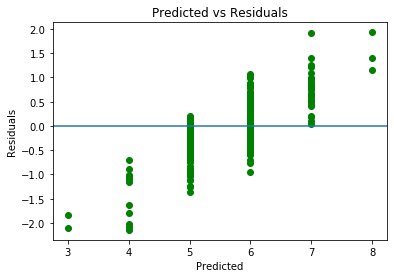

In [793]:
model, result = linear_regression('redwine-quality.csv','quality',';')

With the information returned to us, we can see that the model that performed the best in terms of the best predictive accuracy (lowest RMSE). In this case, the Ridge model performed the best. 
Moreover, the output also shows the feature scores, the higher the number indicates how important that feature is to our model. 
In addition, using the Shapiro-Wilk test it shows that our data is not normal as the p-value is not greater than 0.5 & the Predicted vs Residual shows us that the data is non linear as it does not follow any particular shape and also shows some possible outliers at the start and end of the plot. 